In [ ]:
import pandas as pd

df = pd.read_csv("/content/protein_dataset (120).csv")
df = df.dropna(subset=['Class'])  # Remove rows without class label


In [ ]:
df

,AAs,Nneg,Npos,Exc1,Exc2,I.Index,A.Index,GRAVY,Ser,Thr,Tyr,ExpAA,PredHel,Class
0,94AA,8,9,11585,11460,57.54,70.53,-0.4880,11,3,4,0.00000,0,Defensin
1,100AA,3,6,25565,25440,42.06,127.80,1.0200,8,5,6,66.47000,3,Defensin
2,530AA,55,62,63465,32340,55.76,74.02,-0.0555,42,31,16,0.08910,0,Defensin
3,99AA,8,14,10345,9970,44.13,94.55,-0.1370,2,8,3,0.00300,0,Defensin
4,69AA,10,11,7950,7450,61.94,87.39,-0.1570,2,5,5,22.43500,1,Defensin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,557AA,42,51,16515,16390,37.88,89.89,-0.1160,49,24,11,0.14889,0,RNA Binding Protein
116,364AA,44,42,46105,45730,50.32,66.92,-0.5570,27,22,27,12.80866,0,RNA Binding Protein
117,355AA,45,46,58915,58790,38.99,41.30,-0.9240,28,15,21,0.00550,0,RNA Binding Protein
118,420AA,43,61,52385,52260,49.91,51.88,-0.9520,32,18,24,0.00136,0,RNA Binding Protein


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Keep only numeric columns for model training
X = df.select_dtypes(include=['int64', 'float64'])
y = df['Class']

# Impute missing values in numeric features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Target: 500 samples → samples_per_class = 500 // num_classes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_classes = len(set(y_encoded))
samples_per_class = 500 // num_classes
sampling_strategy = {cls: samples_per_class for cls in set(y_encoded)}

# Apply SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_augmented, y_augmented = smote.fit_resample(X_imputed, y_encoded)


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
X = X_augmented  # Features
y = y_augmented  # Encoded labels

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                       precision    recall  f1-score   support

   DNA Repair Protein       0.88      0.92      0.90        25
        Decarboxylase       0.82      0.92      0.87        25
             Defensin       0.96      0.92      0.94        25
   Heat Shock Protein       0.91      0.84      0.88        25
  RNA Binding Protein       1.00      0.92      0.96        25
Voltage Gated Channel       0.96      1.00      0.98        25

             accuracy                           0.92       150
            macro avg       0.92      0.92      0.92       150
         weighted avg       0.92      0.92      0.92       150



In [ ]:
import joblib

# Save the model
joblib.dump(rf, 'random_forest_protein_model.pkl')

['random_forest_protein_model.pkl']

In [ ]:
rf = joblib.load('random_forest_protein_model.pkl')

In [ ]:
import numpy as np

input_values = np.array([[104,83,62395,61770,51.29,88.23,-0.353,69,45,23,0.00557,0]])

# Predict class
predicted_class_encoded = rf.predict(input_values)[0]
predicted_class = label_encoder.inverse_transform([predicted_class_encoded])[0]

print(f"Predicted Protein Family: {predicted_class}")

Predicted Protein Family: DNA Repair Protein


In [ ]:
!pip install shap

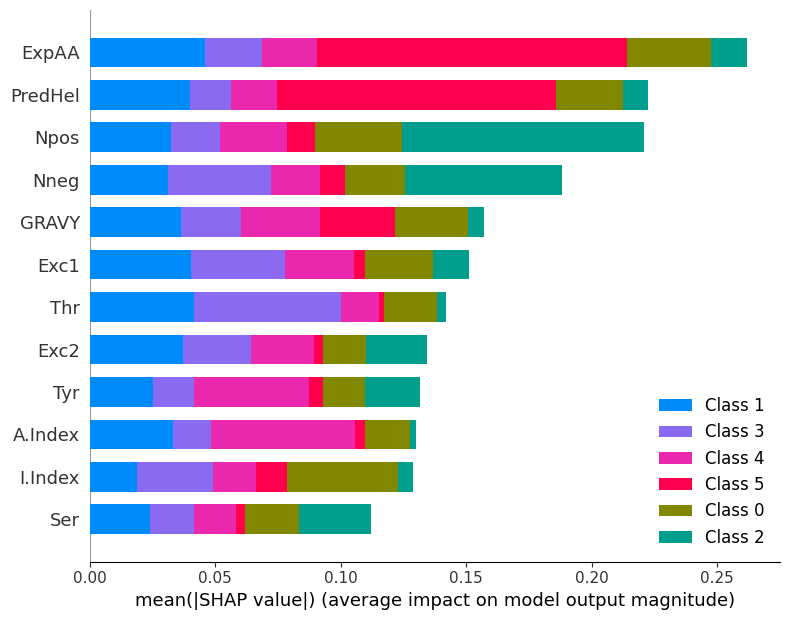

In [ ]:
import shap

# Assuming 'df' is your original Pandas DataFrame
feature_names = df.select_dtypes(include=['int64', 'float64']).columns  # Get feature names

# Create SHAP explainer for tree-based models
explainer = shap.TreeExplainer(rf)

# Pick some test samples (or all)
shap_values = explainer.shap_values(X_test)

# Pass the feature names to the summary_plot function
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)